In [103]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
df = pd.read_csv('../data/250206-passthrough-chuc-4xA100-burn300.csv')
df.reset_index(inplace=True)

drop_everything_before_measure = 'idle'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        focus = df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure')
        focus.reset_index(inplace=True)
        pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
        frames.append(pd.concat([pivot, focus], axis=1))
    range_start = range_end
focus = df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure')
focus.reset_index(inplace=True)
pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
frames.append(pd.concat([pivot, focus], axis=1))

dataset = pd.concat(frames)
dataset.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
dataset = dataset.astype({key:'float' for key in dataset_keys})
dataset.reset_index(inplace=True)

/tmp/ipykernel_12414/2220556779.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_12414/2220556779.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_12414/2220556779.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

In [164]:
dataset = dataset.drop(dataset.loc[dataset['timestamp'] > 240 ].index)
dataset = dataset.drop(dataset.loc[dataset['timestamp'] < 30 ].index)

# Graph time

In [212]:
sns.color_palette("Set2")
sns.set_theme(style="white")

In [194]:
ipmi_keys = [key for key in dataset_keys if 'IPMI' in key]
domain = ['GPU0', 'GPU1', 'GPU2', 'GPU3']
domain_ipmi_keys = domain + ipmi_keys
timestamp_ipmi_keys = ['timestamp'] + domain_ipmi_keys

corr = dataset[domain_ipmi_keys].corr(method = 'spearman')
corr_filtered = corr[:len(domain)][ipmi_keys].T.dropna()

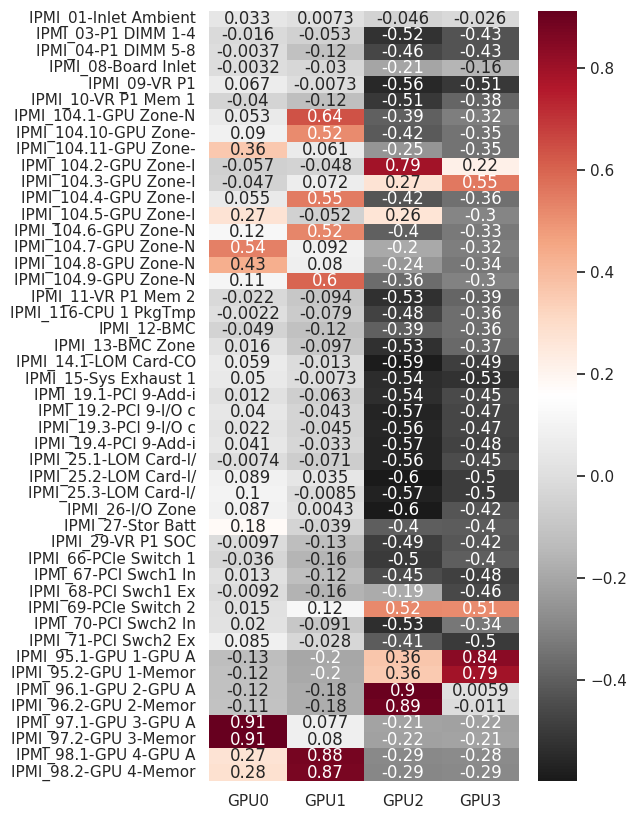

In [205]:
fig, ax = plt.subplots(figsize=(5, 10))  # Set the figure size

sns.heatmap(corr_filtered, ax=ax, annot = True, cmap=sns.color_palette(palette='RdGy_r', as_cmap=True))

plt.gcf().savefig('figures/spearman-corr-ipmi.pdf', bbox_inches='tight')

In [114]:
corr_filtered['GPU0'].idxmax()

'IPMI_97.1-GPU 3-GPU A'

In [256]:
ipmi_correlation = {}
for gpu in domain:
    ipmi_correlation[gpu] = corr_filtered[gpu].idxmax()
    print('For', gpu, 'selecting', ipmi_correlation[gpu])

def attach_sensor_value(row):
    if row['domain'] not in ipmi_correlation.keys(): return None
    return dataset[(dataset["timestamp"] == row["timestamp"]) & (dataset["CONST_context"] == row["CONST_context"]) & (dataset["domain"] == "GPU-X")][ipmi_correlation[row["domain"]]].values[0]
    
dataset['sensor'] = dataset.apply(lambda row : attach_sensor_value(row), axis=1)
dataset_domains = dataset.loc[dataset['domain'].isin(ipmi_correlation.keys())]

dataset_domains = dataset.drop(dataset.loc[dataset['domain'].isin(['GPU-X', 'global'])].index)
dataset_domains['compute'] = dataset_domain.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)

For GPU0 selecting IPMI_97.1-GPU 3-GPU A
For GPU1 selecting IPMI_98.1-GPU 4-GPU A
For GPU2 selecting IPMI_96.1-GPU 2-GPU A
For GPU3 selecting IPMI_95.1-GPU 1-GPU A


/tmp/ipykernel_12414/192521271.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset_domains['compute'] = dataset_domain.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)


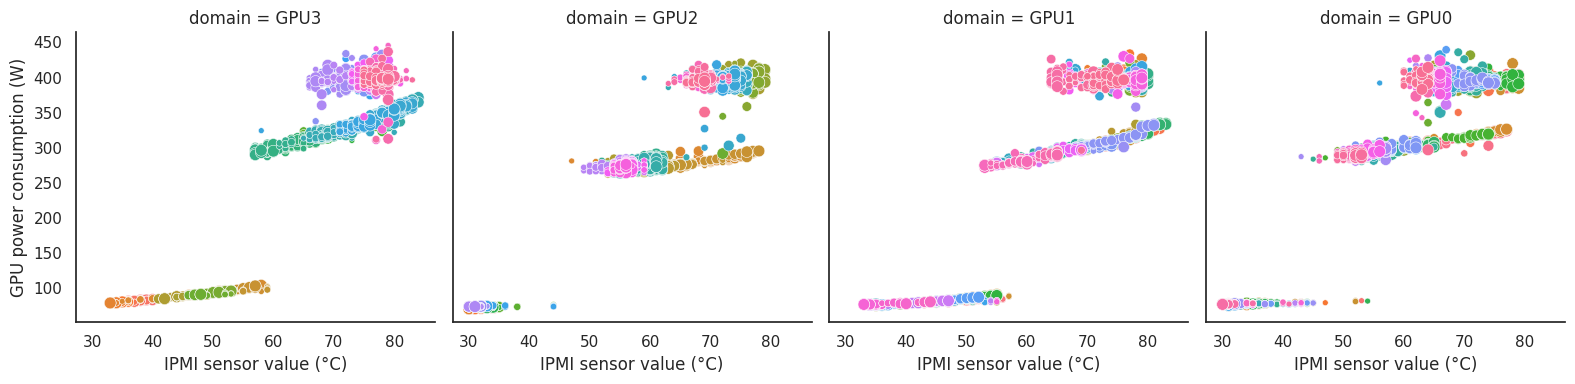

In [213]:
g = sns.relplot(
    data=dataset_domains, x="sensor", y="SMI_power.draw",
    hue="CONST_context", col="domain", height=4, size="timestamp"
)
g.set_axis_labels("IPMI sensor value (°C)", "GPU power consumption (W)")
g._legend.remove()
plt.gcf().savefig('figures/combination-ci-ipmi.pdf', bbox_inches='tight')

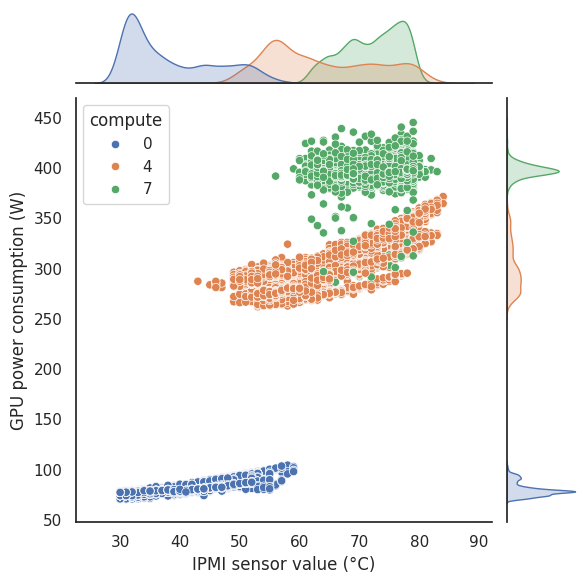

In [263]:
g = sns.jointplot(dataset_domains, x="sensor", y="SMI_power.draw", hue="compute", kind='scatter')
g.set_axis_labels("IPMI sensor value (°C)", "GPU power consumption (W)")
plt.gcf().savefig('figures/static-dyn-comparison.pdf', bbox_inches='tight')
plt.gcf().savefig('figures/combination-ci-ipmi-overview.pdf', bbox_inches='tight')